# Example Run

This package is meant to be fast, flexible, and have support for novel kinds of inference, which we'll walk through.

The model itself isn't complex. The basic idea is that you pass in the spatial coordinates, and get graphs which are essentially just small patches of tissue. It takes in pairwise distances between all the nodes (which captures all the information about local structure) and information about each cell's identity (typically, some batch corrected latent space from a VAE like scVI). You use a graph transformer on the local structure, pool all the latent representations of all the nodes, and then you try to predict the identity of the center cell of the patch. In learning how to do this, the model learns to place similar niches nearby one another, taking in both structural and cell identity information.

This package should run fast enough so that even for large spatial datasets, you can perform quality niche clustering in <20 mins on a laptop.

In [1]:
import pandas as pd
import scanpy as sc

adata = sc.read_h5ad(
    "/home/jhaberbe/Projects/Personal/OCT2025/spatial-transformer/models/17OCT2025/adata-cell-leiden.h5ad"
)

In [2]:
import sys
sys.path.append("/home/jhaberbe/Projects/Fun/rapid-niches")

from rapidniches.data import PairwiseGraphBuilder, GraphTransformerHandler
from rapidniches.model import GraphTransformer

/home/jhaberbe/Projects/Fun/rapid-niches/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading your Dataset

`PairwiseGraphBuilder` takes you cell identities (Typically batch corrected VAE latent representation from a package like scVI), and builds a dataloader. It should take less than a minute, even for large datasets (>>100,000).

In [3]:
# Hacky way to make sure different tissue slides don't overlap.
adata.obs["z_centroid"] = adata.obs["folder"] \
    .replace({k: i * 1000 for i, k in enumerate(adata.obs["folder"].unique())})

# Actual locations, it can be in 2D or 3D
locations = adata.obs[["x_centroid", "y_centroid", "z_centroid"]].values
specimens = adata.obs["folder"].cat.codes.values

/tmp/ipykernel_2563631/366950945.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({k: i * 1000 for i, k in enumerate(adata.obs["folder"].unique())})
/tmp/ipykernel_2563631/366950945.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace({k: i * 1000 for i, k in enumerate(adata.obs["folder"].unique())})


In [10]:
# build the graphs and the dataloader
pgb = PairwiseGraphBuilder(adata.obsm["X_token"], locations, specimens, 20)
dataloader = pgb.create_dataloader(batch_size=2048)

100%|██████████| 423530/423530 [00:31<00:00, 13305.68it/s]


### Training

Model training is usually pretty fast (maybe 10 minutes on laptop). You can use a GPU, which REALLY gets things going.

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GraphTransformer()
handler = GraphTransformerHandler(model, device=device)

Training can take 5 minutes or so. You don't necessarily need to complete a full epoch in order for it to converge.

In [12]:
handler.train(dataloader, num_epochs=10)

Epoch 1/10: 100%|██████████| 207/207 [00:26<00:00,  7.95it/s, Batch Loss=7.1752]


Epoch 1 Loss: 10.1869


Epoch 2/10: 100%|██████████| 207/207 [00:26<00:00,  7.92it/s, Batch Loss=6.5013]


Epoch 2 Loss: 6.7389


Epoch 3/10: 100%|██████████| 207/207 [00:26<00:00,  7.90it/s, Batch Loss=5.7537]


Epoch 3 Loss: 6.1365


Epoch 4/10: 100%|██████████| 207/207 [00:26<00:00,  7.89it/s, Batch Loss=5.5092]


Epoch 4 Loss: 5.8047


Epoch 5/10: 100%|██████████| 207/207 [00:26<00:00,  7.89it/s, Batch Loss=5.3867]


Epoch 5 Loss: 5.5432


Epoch 6/10: 100%|██████████| 207/207 [00:26<00:00,  7.91it/s, Batch Loss=5.2484]


Epoch 6 Loss: 5.3132


Epoch 7/10: 100%|██████████| 207/207 [00:26<00:00,  7.85it/s, Batch Loss=4.8217]


Epoch 7 Loss: 5.1639


Epoch 8/10: 100%|██████████| 207/207 [00:26<00:00,  7.94it/s, Batch Loss=4.9257]


Epoch 8 Loss: 5.0360


Epoch 9/10: 100%|██████████| 207/207 [00:28<00:00,  7.26it/s, Batch Loss=4.9133]


Epoch 9 Loss: 4.9532


Epoch 10/10: 100%|██████████| 207/207 [00:26<00:00,  7.93it/s, Batch Loss=4.6972]

Epoch 10 Loss: 4.8769


Looking at the training history, we can see the model converges very quickly and seems to perform consistently across shuffled batches after about 100 epochs.

Final batch loss: 4.697152614593506


<Axes: >

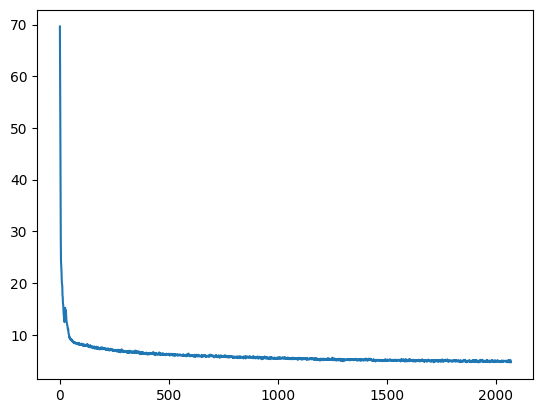

In [151]:
import numpy as np
import pandas as pd

# Get training history
history = handler.get_training_history()
print(f"Final batch loss: {history['batch_losses'][-1]}")
pd.Series(history['batch_losses']).plot()

### Reproducibility

Saving the output is very easy.

In [18]:
# Save the model
handler.save_checkpoint("checkpoint.pth")
handler.save_model("saved_model/")

Checkpoint saved to checkpoint.pth
Model saved to saved_model/


So is loading it 

In [19]:
# Load the model
handler = GraphTransformerHandler.load_model("saved_model/", GraphTransformer)

Model loaded from saved_model/


### Clustering

Getting the latent representation is about as fast as training is. For a dataset of about 400,000 it took a few minutes. It will vary depending on the number of nearest neighbors that you use.

In [20]:
# Get latent representations (graph transformer only)
latent_repr = handler.predict_latent(dataloader)
adata.obsm["latent"] = latent_repr
print(f"Latent representations shape: {latent_repr.shape}")

/home/jhaberbe/Projects/Fun/rapid-niches/rapidniches/data.py:219: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  unshuffled_dataloader = DataLoader(


Using temporary unshuffled dataloader for consistent latent representations


Predicting Latent Representations:   0%|          | 0/207 [00:00<?, ?it/s]/home/jhaberbe/Projects/Fun/rapid-niches/.venv/lib/python3.12/site-packages/torch_geometric/data/data.py:187: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_attr', 'edge_index', 'specimen', 'target', 'X'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  return sum([v.num_nodes for v in self.node_stores])
/home/jhaberbe/Projects/Fun/rapid-niches/.venv/lib/python3.12/site-packages/torch_geometric/data/collate.py:142: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_attr', 'edge_index', 'specimen', 'target', 'X'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  repeats = [store.num_nodes or 0 for store in stores]
Predicting Latent Representations: 100%|██████████| 207/207 [00:16<00:00, 12.63it/s]

Latent representations shape: (423530, 16)


Clustering is done how you might for PCA / scVI coordinates. It takes around as long to cluster as it does to train the model and get the latent representation

In [21]:
sc.pp.neighbors(adata, use_rep="latent")
sc.tl.umap(adata)

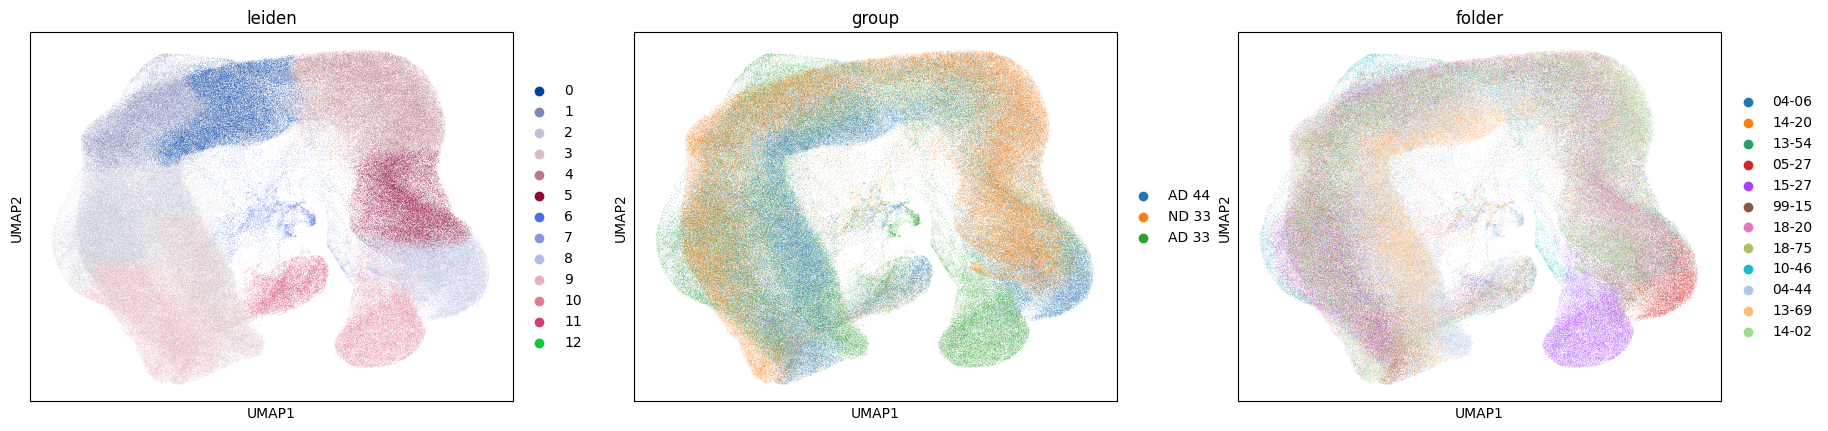

In [22]:
sc.tl.leiden(adata, n_iterations=2, flavor="igraph", resolution=0.3)
sc.pl.umap(adata, color=["leiden", "group", "folder"], color_map="tab20")

The plot below will show that the model is able to find large tracts of similar tissue types. However, it is also able to identify finer structure, such as blood vessels. These representations end up being relatively robust between groups, but this will depend on the quality of your batch correction in your tokenizing of cells.

<Axes: xlabel='x_centroid', ylabel='y_centroid'>

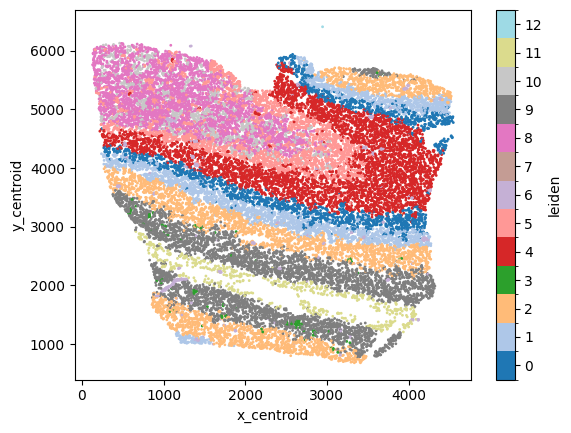

In [123]:
import plotly.express as px

adata.obs.query("folder=='99-15'").plot.scatter(
    x="x_centroid",
    y="y_centroid",
    c="leiden",
    cmap="tab20",
    s=1
)

<Axes: xlabel='x_centroid', ylabel='y_centroid'>

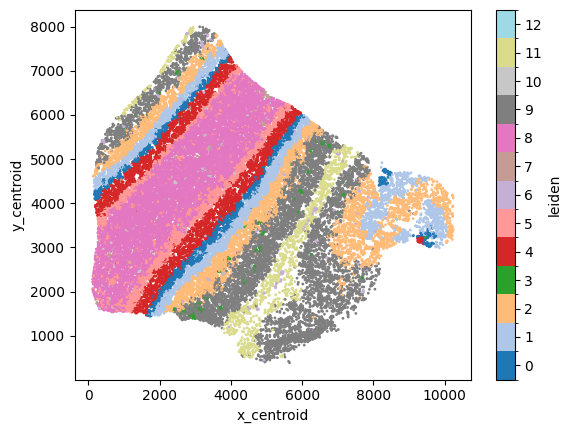

In [124]:
import plotly.express as px

folder="05-27"

adata.obs.query("folder==@folder").plot.scatter(
    x="x_centroid",
    y="y_centroid",
    c="leiden",
    cmap="tab20",
    s=1
)

# Additional Batteries

Because of the way its trained, we get some extra inference machinery for free. We use a normalizing flow, so when we pass in a niche token and the cell token, we actually get information about the log-probability of any given token existing within a particular spatial niche. So, for two different tokens from the same cell type, with different identities, you can compute the likelihood of finding the given cells within a certain environment, and see whether there are regions where one is more likely than the other, which might give you some interesting information. This value you get out of this portion depends on the ability of your VAE to distinguish cells of the same type based on that gene's expression, so it may make sense to make your VAE more expressive.

For the purpose of this example, I'm going to take two groups of Microglia-PVM cells. One is GPNMB-high, which is a marker for Microglia activation in the context of amyloid pathology in our dataset. We'll compare it against GPNMB-low P2RY12-high Microglia-PVM, which represent homeostatic Microglia-PVM. The logic here involves using a cKDTree (fast neighbor lookup) to pick cells from each of these groups that are already close to the niche of each cell. This is because the cell tokens themselves carry some information about which niche they're likely to be in, and I ideally want to minimize the dependence on that fact as much as possible. An ideal result would be that we get relatively reproducible (two graph transformers trained separately arrive at close to the same conclusion) estimates of neighborhood density for the same tested population.

The normalizing flow head is significantly faster than the inference portion, so you should be able to do this in around minute even with extremely large datasets.

There is a tradeoff between speed and brittleness, so you should adjust your number of neighbors accordingly.

In [157]:
import scipy.spatial
import numpy as np
from scipy.special import logsumexp

n_neighbors = 20

# Find the n_neighbors nearest neighbors in niche space for each cell for activated microglia.
gpnmb_high_coordinates = adata[
    adata.obs["cell_type"].eq("Microglia-PVM")
    & (adata[:, "GPNMB"].X[:, 0] > 2)
].obsm["latent"]

_, gpnmb_high_indices = scipy.spatial.cKDTree(gpnmb_high_coordinates).query(
    adata.obsm["latent"],
    k=n_neighbors
)

# Find the n_neighbors nearest neighbors in niche space for each cell for homeostatic microglia.
gpnmb_low_coordinates = adata[
    adata.obs["cell_type"].eq("Microglia-PVM")
    & (adata[:, "GPNMB"].X[:, 0] < 1)
    & (adata[:, "P2RY12"].X[:, 0] > 2)
].obsm["latent"]

_, gpnmb_low_indices = scipy.spatial.cKDTree(gpnmb_low_coordinates).query(
    adata.obsm["latent"],
    k=n_neighbors
)

# Get all tokens
activated_all_tokens = adata[
    adata.obs["cell_type"].eq("Microglia-PVM")
    & (adata[:, "GPNMB"].X[:, 0] > 2)
].obsm["X_token"]

homeostatic_all_tokens = adata[
    adata.obs["cell_type"].eq("Microglia-PVM")
    & (adata[:, "GPNMB"].X[:, 0] < 1)
    & (adata[:, "P2RY12"].X[:, 0] > 2)
].obsm["X_token"]

# Vectorized computation for activated microglia
activated_neighbor_tokens = torch.tensor(activated_all_tokens[gpnmb_high_indices.reshape(-1)])
activated_latent_repeated = torch.tensor(adata.obsm["latent"]).repeat_interleave(n_neighbors, dim=0)
activated_logps = handler.predict_flow_with_custom_context(activated_neighbor_tokens, activated_latent_repeated)
adata.obs["activated_microglia_logp"] = logsumexp(activated_logps.reshape(-1, n_neighbors), axis=1) - np.log(10)

# Vectorized computation for homeostatic microglia
homeostatic_neighbor_tokens = torch.tensor(homeostatic_all_tokens[gpnmb_low_indices.reshape(-1)])
homeostatic_latent_repeated = torch.tensor(adata.obsm["latent"]).repeat_interleave(n_neighbors, dim=0)
homeostatic_logps = handler.predict_flow_with_custom_context(homeostatic_neighbor_tokens, homeostatic_latent_repeated)
adata.obs["homeostatic_microglia_logp"] = logsumexp(homeostatic_logps.reshape(-1, n_neighbors), axis=1) - np.log(10)

In [158]:
adata.obs["activated_microglia_logp"] = logsumexp(activated_logps.reshape(-1, n_neighbors), axis=1) - np.log(10)
adata.obs["homeostatic_microglia_logp"] = logsumexp(homeostatic_logps.reshape(-1, n_neighbors), axis=1) - np.log(10)

Plotting these, we can tell there are definitely differences in the spatial arrangement of the two different types of cells.

Text(0.5, 1.0, 'Activated Microglia')

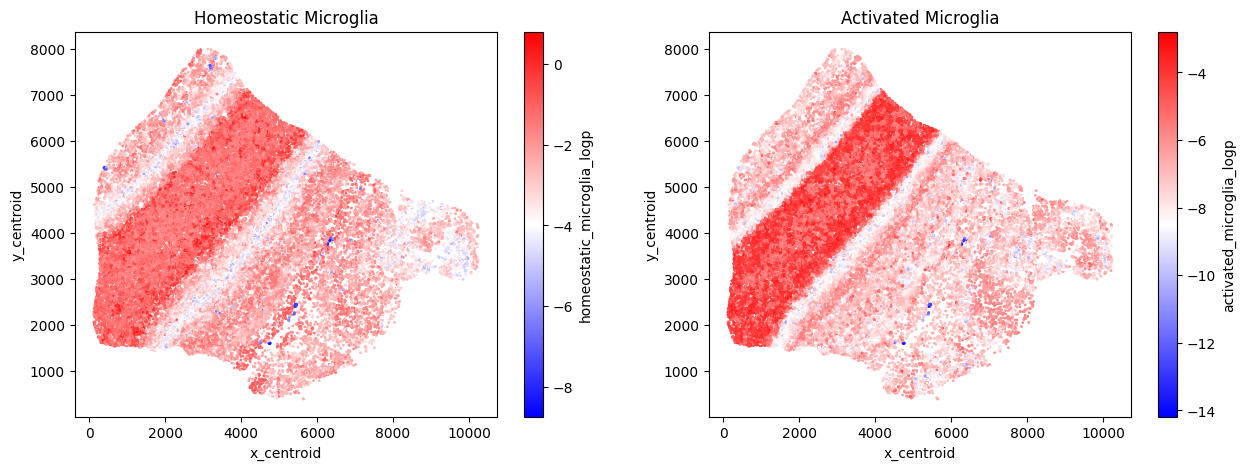

In [160]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(ncols=2, figsize=(15, 5))

folder = "05-27"

adata.obs.query("folder==@folder").plot.scatter(
    x="x_centroid",
    y="y_centroid",
    c="homeostatic_microglia_logp",
    cmap="bwr",
    s=1,
    ax=ax[0]
)
ax[0].set_title("Homeostatic Microglia")

adata.obs.query("folder==@folder").plot.scatter(
    x="x_centroid",
    y="y_centroid",
    c="activated_microglia_logp",
    cmap="bwr",
    s=1,
    ax=ax[1]
)
ax[1].set_title("Activated Microglia")

We can take the likelihood ratio of the two, and use that to determine relative preference for each.

<Axes: xlabel='x_centroid', ylabel='y_centroid'>

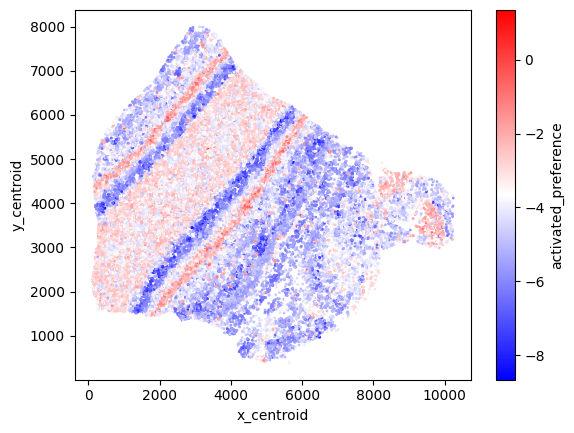

In [161]:
import numpy as np
adata.obs["activated_preference"] = (
    adata.obs["activated_microglia_logp"] 
    - adata.obs["homeostatic_microglia_logp"]
)

ax = adata.obs.query("folder==@folder").plot.scatter(
    x="x_centroid",
    y="y_centroid",
    c="activated_preference",
    cmap="bwr",
    s=1
)

adata[adata.obs["cell_leiden"].eq("2") & adata[:, "GPNMB"].X[:, 0] > 2].obs.query("folder==@folder").plot.scatter(
    x="x_centroid",
    y="y_centroid",
    c="k",
    s=10,
    ax = ax
)

This feature is more brittle than the niche inference. I would suggest taking around 20 nearest neighbors at least, depending on the size of your dataset. Users should take multiple runs to validate these results are accurate.

However, the result is pretty cool. The neurons layer you see is deep-layer intratelencephalic neurons, which have high expression of CENPF, COL12A1, and SPHKAP relative to other neurons. [Apparently](https://pubmed.ncbi.nlm.nih.gov/35948630/), others have found in biological experiments that pyramidal neuron identity also influences the distribution of microglial cells. 

In [121]:
adata.write_h5ad("/home/jhaberbe/Projects/Fun/rapid-niches/data/activation_preference.h5ad")